# Neural Net
## Deep Learning course -- Lab Exercise 2

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)

In [1]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

# Data

In [2]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    # this link doesn't work any more,
    # seach on google for the file "mnist.pkl.gz"
    # and download it
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

In [3]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 9


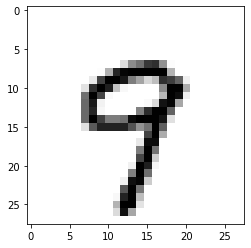

In [4]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [5]:
class Tensor:
  def __init__(self, data, require_grad=False):
    # test type of data: should be np array
    if isinstance(data, float):
        data = np.array([data,])
    if type(data) != np.ndarray:
        raise RuntimeError("Input should be a numpy array")

    # store data for this tensor
    self.data = data
    self.require_grad = require_grad
    
    # these values should be set to enable autograd!
    self.gradient = None
    self.d = None
    self.backptr = None
      
  def zero_grad(self):
    """
    Set the gradient of this tensor to 0
    """
    if self.require_grad:
        self.gradient = np.zeros_like(self.data)
          
  def accumulate_gradient(self, gradient):
    """
    Accumulate gradient for this tensor
    """
    if gradient.shape != self.data.shape:
        raise RuntimeError("Invalid gradient dimension")

    if self.gradient is None:
        self.gradient = np.copy(gradient)
    else:
        self.gradient += gradient
          
  def backward(self, g=None):
    """
    The backward pass!
    If g != None, then g is the gradient for the current node.
    i.e. g will be != None only for the loss output.
    
    You should call the function stored in self.d with correct arguments,
    and then recursively call the backward methods of tensors in the backptr list if:
    1. they require a gradient
    2. they are of type Tensor: check with isinstance(o, Tensor)
    """
    if not self.require_grad:  # stop right now if this node does not require a gradient
        return
    
    if g is not None:
      if isinstance(g, float):
        g = np.array([g])
      if type(g) != np.ndarray:
        raise RuntimeError("Gradient should be a numpy array")
      if g.shape != self.data.shape:
        raise RuntimeError("Gradient of different size than the value!")
          
      self.gradient = g


    self.d(self.backptr, self.gradient)

    for o in self.backptr:
      if isinstance(o, Tensor) and not isinstance(o, Parameter) and o.require_grad:
        o.backward()
    
    
class Parameter(Tensor):
  """
  This class will be used to store parameters of the network only!
  """
  def __init__(self, data, name="unamed"):
    super().__init__(data, require_grad=True)
    self.name = name
      
  def backward(self):
    raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [6]:
def any_require_grad(l):
  """
  Input:
  - l: an iterable (e.g. a list)
  Ouput:
  - True if any tensor in the input requires a gradient
  """
  return any(t.require_grad for t in l)

In [7]:
# Here is an exemple with the ReLU
def relu(x):
  v = np.maximum(0, x.data)
  
  output = Tensor(v, require_grad=x.require_grad)
  output.d = backward_relu
  output.backptr = [x]
  
  return output

def backward_relu(backptr, g):
  x, = backptr
  
  # the gradient is accumulated in the arguments only if required
  if x.require_grad:
      x.accumulate_gradient(g * (x.data > 0))

In [8]:
def tanh(x):
  v = np.tanh(x.data)

  output = Tensor(v, require_grad=x.require_grad)
  output.d = backward_tanh
  output.backptr = [x]
    
  return output


def backward_tanh(backptr, g):
  x, = backptr

  if x.require_grad:
    x.accumulate_gradient(g * (1 - np.square(np.tanh(x.data))))

Next, we implement the affine transform operation.

In [9]:
def affine_transform(W, b, x):
  v = W.data @ x.data + b.data
  
  output = Tensor(v, require_grad=any_require_grad((W, b, x)))
  output.d = backward_affine_transform
  output.backptr = [W, b, x]

  return output

def backward_affine_transform(backptr, g):
  W, b, x = backptr
  
  # the gradient is accumulated in the arguments only if required
  if W.require_grad:
    W.accumulate_gradient(g.reshape(-1, 1) @ x.data.reshape(-1, 1).T)
  if b.require_grad:
    b.accumulate_gradient(g)
  if isinstance(x, Tensor) and x.require_grad:
    # (10, 100) (10,) (100,) (10,)
    #print(W.data.shape, b.data.shape, x.data.shape, g.shape)
    x.accumulate_gradient(W.data.T @ g)

In [10]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
  def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()
  e_n = exp_normalize(x)
  return e_n / e_n.sum()

def nll(x, gold):
  b = x.data.max()
  logsumexp = b + np.log(np.exp( x.data - b).sum())
  v = -(x.data[gold] - logsumexp)

  output = Tensor(v, require_grad=x.require_grad)
  output.d = backward_nll
  output.backptr = [x, gold]

  return output

def backward_nll(backptr, g):
  x, gold = backptr

  if x.require_grad:
    v = _softmax(x.data)
    v[gold] -= 1
    x.accumulate_gradient(g * v)

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [11]:
class Module:
  def __init__(self):
    raise NotImplemented("")
        
  def parameters(self):
    ret = []
    for name in dir(self):
      o = self.__getattribute__(name)

      if type(o) is Parameter:
        ret.append(o)
      if isinstance(o, Module) or isinstance(o, ModuleList):
        ret.extend(o.parameters())
    return ret
    
  def save_parameters(self) -> dict:
    """
    This method saves all the parameters of the network in a dictionary along with their data.

    Returns
    -------
    dict: `dict`
        A dictionnary of the form {parameter: parameter.data}.
    """
    ret = {}
    for p in self.parameters():
      ret[p] = p.data.copy()
    return ret
    
  def load_parameters(self, dict_params: dict):
    """
    This method sets the value of all the parameters of the network using a dictionary.

    Parameters
    ----------
    dict_params: `dict`
        A dictionnary of the form {parameter: parameter.data}.
    """
    for p in self.parameters():
      p.data[:] = dict_params[p]

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
  def parameters(self):
    ret = []
    for m in self:
      if type(m) is Parameter:
        ret.append(m)
      elif isinstance(m, Module) or isinstance(m, ModuleList):
        ret.extend(m.parameters())
    return ret

# Initialization and optimization

In [12]:
def zero_init(b):
  b[:] = 0.

def glorot_init(W):
  r = np.sqrt(6) / np.sqrt(W.shape[1] + W.shape[0])
  W[:] = np.random.uniform(low=-r, high=r, size=W.shape)
    
# Look at slides for the formula!
def kaiming_init(W):
  r = np.sqrt(6) / np.sqrt(W.shape[1])
  W[:] = np.random.uniform(low=-r, high=r, size=W.shape)

In [13]:
# simple gradient descent optimizer
class SGD:
  def __init__(self, params, lr=0.1):
    self.params = params
    self.lr = lr
        
  def step(self):
    for p in self.params:
      p.data[:] = p.data - self.lr * p.gradient
        
  def zero_grad(self):
    for p in self.params:
      p.zero_grad()

# Networks and training loop

We first create a simple linear classifier.

In [14]:
class LinearNetwork(Module):
  def __init__(self, dim_input, dim_output):
    # build the parameters
    self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
    self.b = Parameter(np.ndarray((dim_output,)), name="b")
    
    self.init_parameters()
        
  def init_parameters(self):
    # init parameters of the network (i.e W and b)
    glorot_init(self.W.data)
    zero_init(self.b.data)
        
  def forward(self, x):
    return affine_transform(self.W, self.b, x)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [15]:
def plot_results(history, n_epochs):
  x = range(0, n_epochs)
  plt.figure(figsize=(8, 5))
  plt.plot(x, history["losses"], color='r', label="Average loss")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

  plt.figure(figsize=(8, 5))
  plt.plot(x, history["train_acc"], color='g', label="Train accuracy")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

  plt.figure(figsize=(8, 5))
  plt.plot(x, history["dev_acc"], color='b', label="Dev accuracy")
  plt.xlabel("Epoch")
  plt.legend()
  plt.show()

In [16]:
def get_accuracy(set, network) -> float:
  """
  This function computes the accuracy over the set `set` using the model in `network`.

  Parameters
  ----------
  set: `Iterable`
      A set of data.
  network: `Any`
          A model.
  
  Returns
  -------
  accuracy: `float`
           The accuracy of the model over the set.
  """
  accuracy = 0
  for data, gold in zip(set[0], set[1]):
    y_hat = network.forward(data)
    accuracy += gold == np.argmax(y_hat.data)
  return accuracy / set[0].shape[0]

In [17]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs=10):
  # Array containing some stats
  avg_losses = np.zeros(n_epochs)
  train_acc = np.zeros(n_epochs)
  dev_acc = np.zeros(n_epochs)

  # Parameters for which the score over the dev set was the highest
  best_params = None
  best_score  = -np.inf

  for epoch in range(n_epochs):
    cum_accuracy = 0
    cum_loss = 0

    for i in np.random.permutation(train_data[0].shape[0]):
      data, gold = train_data[0][i], train_data[1][i]

      y_hat = network.forward(Tensor(data))

      cum_accuracy += gold == np.argmax(y_hat.data)

      optimizer.zero_grad()
      loss = nll(y_hat, gold)
      loss.backward(1.0)
      optimizer.step()

      cum_loss += loss.data

    # Compute avg loss, avg train accuracy and dev accuracy
    avg_losses[epoch] = cum_loss / train_data[0].shape[0]
    train_acc[epoch]  = cum_accuracy / train_data[0].shape[0]
    dev_acc[epoch]  = get_accuracy(dev_data, network)

    # If the dev accuracy of this epoch is the highest, we save the network's parameters
    if dev_acc[epoch] > best_score:
      best_score = dev_acc[epoch]
      best_params = network.save_parameters()

    print(f"Epoch {epoch + 1}/{n_epochs}")
    print(f"Average loss: {avg_losses[epoch]:.3f}")
    print(f"Train accuracy: {train_acc[epoch]}")
    print(f"Dev accuracy: {dev_acc[epoch]}")

  return {"losses": avg_losses, "train_acc": train_acc, "dev_acc": dev_acc}, best_params

Epoch 1/5
Average loss: 0.377
Train accuracy: 0.89148
Dev accuracy: 0.9112
Epoch 2/5
Average loss: 0.311
Train accuracy: 0.91168
Dev accuracy: 0.9229
Epoch 3/5
Average loss: 0.298
Train accuracy: 0.91544
Dev accuracy: 0.9244
Epoch 4/5
Average loss: 0.290
Train accuracy: 0.91804
Dev accuracy: 0.9231
Epoch 5/5
Average loss: 0.286
Train accuracy: 0.91992
Dev accuracy: 0.9131
Test accuracy: 0.9187


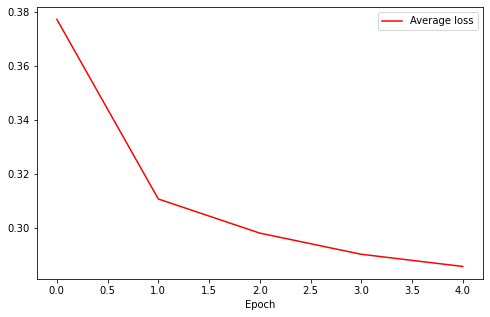

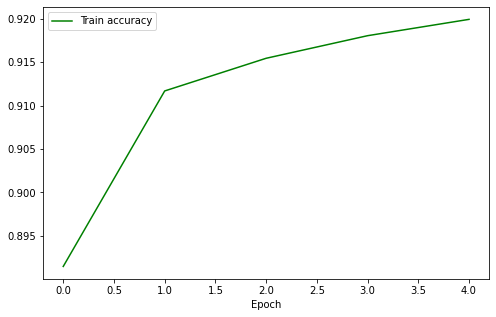

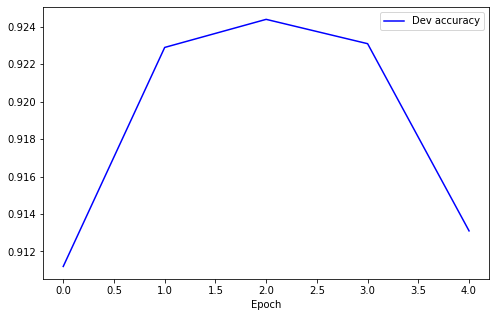

In [18]:
dim_input = 28*28
dim_output = 10

network = LinearNetwork(dim_input, dim_output)
optimizer = SGD(network.parameters(), 0.01)
n_epochs = 5

history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=n_epochs)

# Test evaluation
network.load_parameters(best_params)
print(f"Test accuracy: {get_accuracy(test_data, network)}")
plot_results(history, n_epochs)

After you finished the linear network, you can move to a deep network!

In [19]:
class DeepNetwork(Module):
  def __init__(self, dim_input, dim_output, hidden_dim, n_layers, use_tanh=False):
    self.W = ModuleList()
    self.b = ModuleList()

    self.activation = tanh if use_tanh else relu
    self.init       = glorot_init if use_tanh else kaiming_init
    
    for i in range(n_layers):
      d_i = hidden_dim
      if i == 0:
        d_i = dim_input

      self.W.append(Parameter(np.ndarray((hidden_dim, d_i)), name=f"W_{i}"))
      self.b.append(Parameter(np.ndarray((hidden_dim,)), name=f"b_{i}"))

    if n_layers == 0: hidden_dim = dim_input
    self.output_proj = Parameter(np.ndarray((dim_output, hidden_dim)), name=f"W")
    self.output_bias = Parameter(np.ndarray((dim_output,)), name=f"b")
    
    self.init_parameters()
      
  def init_parameters(self):
    for w, b in zip(self.W, self.b):
      self.init(w.data)
      zero_init(b.data)

    glorot_init(self.output_proj.data)
    zero_init(self.output_bias.data)

  def forward(self, x):
    for w, b in zip(self.W, self.b):  
      x = affine_transform(w, b, x)
      x = self.activation(x)
    return affine_transform(self.output_proj, self.output_bias, x)

Epoch 1/5
Average loss: 0.258
Train accuracy: 0.9202
Dev accuracy: 0.9558
Epoch 2/5
Average loss: 0.120
Train accuracy: 0.9624
Dev accuracy: 0.9662
Epoch 3/5
Average loss: 0.084
Train accuracy: 0.97392
Dev accuracy: 0.97
Epoch 4/5
Average loss: 0.062
Train accuracy: 0.98066
Dev accuracy: 0.9728
Epoch 5/5
Average loss: 0.050
Train accuracy: 0.9838
Dev accuracy: 0.9683
Test accuracy: 0.9699


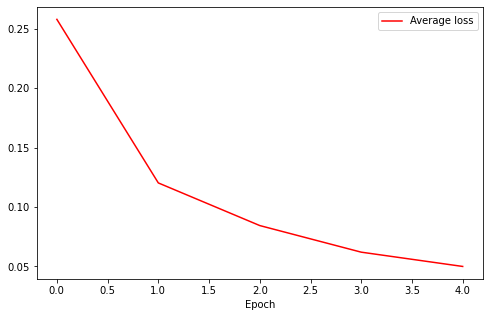

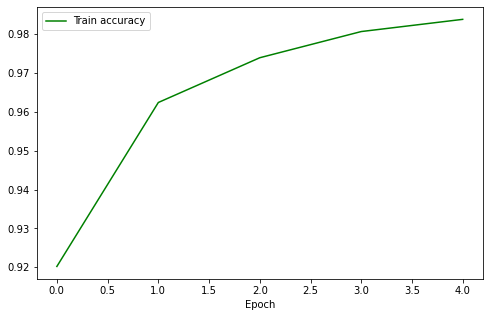

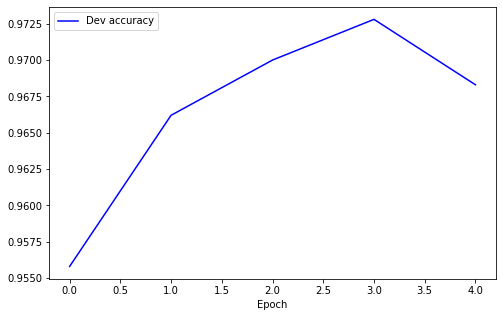

In [20]:
network = DeepNetwork(dim_input, dim_output, 100, 2, use_tanh=True)
optimizer = SGD(network.parameters(), 0.01)

history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=n_epochs)

# Test evaluation
network.load_parameters(best_params)
print(f"Test accuracy: {get_accuracy(test_data, network)}")
plot_results(history, n_epochs)

Epoch 1/5
Average loss: 0.246
Train accuracy: 0.92406
Dev accuracy: 0.9635
Epoch 2/5
Average loss: 0.119
Train accuracy: 0.9635
Dev accuracy: 0.9639
Epoch 3/5
Average loss: 0.087
Train accuracy: 0.97226
Dev accuracy: 0.9712
Epoch 4/5
Average loss: 0.070
Train accuracy: 0.97818
Dev accuracy: 0.9717
Epoch 5/5
Average loss: 0.059
Train accuracy: 0.98194
Dev accuracy: 0.9718
Test accuracy: 0.9725


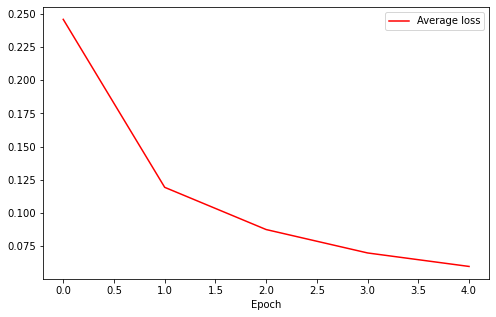

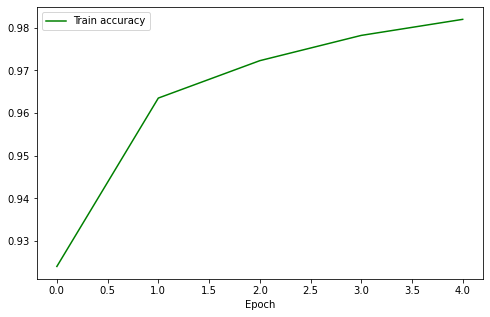

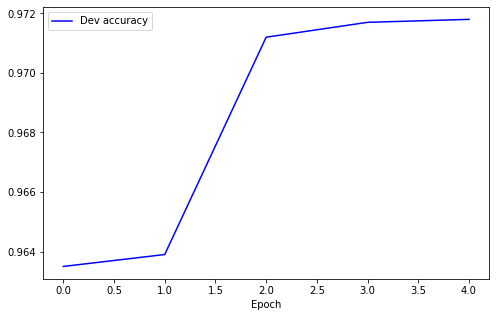

In [21]:
network = DeepNetwork(dim_input, dim_output, 100, 2)
optimizer = SGD(network.parameters(), 0.01)

history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=n_epochs)

# Test evaluation
network.load_parameters(best_params)
print(f"Test accuracy: {get_accuracy(test_data, network)}")
plot_results(history, n_epochs)

## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


In [22]:
class MomentumSGD:
  def __init__(self, params, lr=0.1, momentum=0.3):
    self.params = params
    self.lr = lr
    self.momentum = momentum

    # Contains the velocity of each parameter
    self.velocity = {}
      
  def step(self):
    for p in self.params:
      if p.gradient is None:
        continue
        
      if self.momentum != 0:
        if p in self.velocity:
          self.velocity[p] = self.momentum * self.velocity[p] + p.gradient
          p.gradient = self.velocity[p]
        else:
          # If it's the first time the optimizer see this parameter, then its velocity is just its gradient
          self.velocity[p] = p.gradient.copy()

      p.data[:] = p.data - self.lr * p.gradient

  def zero_grad(self):
    for p in self.params:
      p.zero_grad()

Epoch 1/5
Average loss: 0.257
Train accuracy: 0.92206
Dev accuracy: 0.9579
Epoch 2/5
Average loss: 0.129
Train accuracy: 0.9603
Dev accuracy: 0.9649
Epoch 3/5
Average loss: 0.092
Train accuracy: 0.9716
Dev accuracy: 0.9665
Epoch 4/5
Average loss: 0.070
Train accuracy: 0.9777
Dev accuracy: 0.9732
Epoch 5/5
Average loss: 0.055
Train accuracy: 0.9819
Dev accuracy: 0.9674
Test accuracy: 0.9704


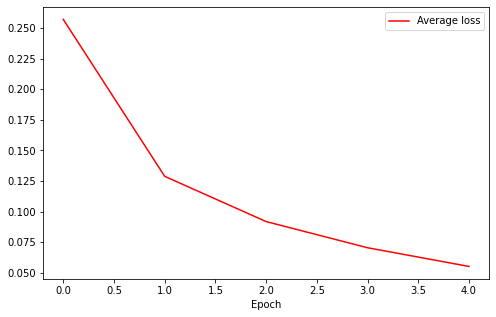

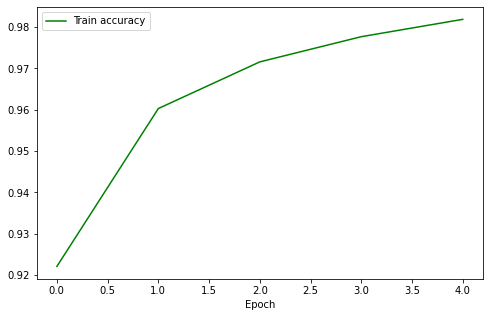

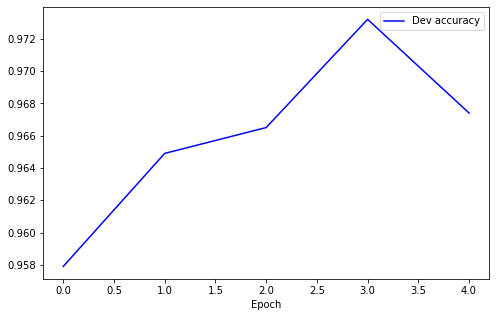

In [23]:
network = DeepNetwork(dim_input, dim_output, 100, 2, use_tanh=True)
optimizer = MomentumSGD(network.parameters(), 0.01)

history, best_params = training_loop(network, optimizer, train_data, dev_data, n_epochs=n_epochs)

# Test evaluation
network.load_parameters(best_params)
print(f"Test accuracy: {get_accuracy(test_data, network)}")
plot_results(history, n_epochs)